In [2]:
cd ATML-PA-2/Baseline
ls

SyntaxError: invalid syntax (2971391446.py, line 1)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import importlib
import utils
import architecture
import train
importlib.reload(utils)
importlib.reload(architecture)
importlib.reload(train)


from utils.dataset import FeatureTensorDataset, OfficeHomeDataset, _truncate_resnet_from
from torchvision.models import ResNet50_Weights
from importlib import reload
import train
from train import train_workflow
import types
from utils.tsne import tsne_plot, get_features
from utils.evaluation import evaluate_ds
import matplotlib.pyplot as plt
import os
from architecture import resnet_classifier
import torch

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
root_dir = "../datasets/OfficeHomeDataset"
csv_file = f"{root_dir}/ImageInfo.csv"

transform = ResNet50_Weights.IMAGENET1K_V1.transforms()
classes = os.listdir(f"{root_dir}/Art")
domains = ['Real World', 'Art', 'Clipart', 'Product']

In [17]:
import matplotlib.pyplot as plt

def analysis(config, model, cache_source=None, cache_target=None):
    train_workflow(model, cache_source, cache_target, config, device=device)
    evaluate_ds(cache_target, model, device)

    latents_s, _ = get_features(model[:-1], cache_source, batchsize=32, device=device)
    latents_t, _ = get_features(model[:-1], cache_target, batchsize=32, device=device)

    latents_s = latents_s.flatten(start_dim=1)
    latents_t = latents_t.flatten(start_dim=1)

    latents = torch.cat([latents_s, latents_t], dim=0)
    domain_labels = torch.cat([
        torch.zeros(len(latents_s), dtype=torch.long),
        torch.ones(len(latents_t), dtype=torch.long)
    ])

    fig, ax = plt.subplots(figsize=(8, 6))
    tsne_plot(latents, domain_labels, classes=["Source", "Target"], ax=ax, fig=fig, perplexity=30)
    plt.title("t-SNE Domain Clustering: Source vs Target")
    plt.show()

In [29]:
def get_domain_ds(domains, transform=None):
    return OfficeHomeDataset(root_dir, csv_file, domains, transform)

def combine_caches(caches):
    return torch.utils.data.ConcatDataset(caches)

def make_cache(domains, model, transforms=None, layer_name='layer3'):
    ds = OfficeHomeDataset(root_dir, csv_file, domains, transforms)
    return FeatureTensorDataset(ds, model, layer_name, device=device, batch_size=32)

def build_model(truncate_from):
    model = resnet_classifier( 
        num_classes=len(classes),
    )
    return _truncate_resnet_from(model, truncate_from)


In [20]:
model = resnet_classifier(num_classes=len(classes))

cache_store = {}
for domain in domains:
    cache_store[domain] = make_cache([domain], model, transform, "layer3")
    print(f"Cached {domain}")

Precomputing up to layer3: 100%|██████████| 137/137 [02:17<00:00,  1.00s/it]


Cached Real World


Precomputing up to layer3: 100%|██████████| 76/76 [00:42<00:00,  1.79it/s]


Cached Art


Precomputing up to layer3: 100%|██████████| 137/137 [00:57<00:00,  2.39it/s]


Cached Clipart


Precomputing up to layer3: 100%|██████████| 139/139 [00:58<00:00,  2.39it/s]


Cached Product


In [21]:
pairs = [
    # Low-shift
    ("Product", "Real World"),
    ("Art", "Clipart"),

    # Medium-shift
    ("Product", "Art"),
    ("Art", "Real World"),

    # High-shift
    ("Real World", "Clipart"),
    ("Product", "Clipart")
]

In [ ]:
config = {'epochs':10, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-3}



source, target = ("Product", "Real World")
model = build_model(truncate_from='layer3')
print(model)
model.layer4.grad = False 
analysis(config, model, cache_store[source], cache_store[target])

Sequential(
  (layer4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0

Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10

Train loss: 1.55289 |  Train acc: 66.75 %



Training:   0%|          | 0/10 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
source, target = ("Art", "Real World"),
model = build_model(truncate_from='layer3')
model.layer3.grad = False 
analysis(config, cache_store[source], cache_store[target])

In [ ]:
source, target = ("Real World", "Clipart")
model = build_model(truncate_from='layer3')
model.layer3.grad = False 
analysis(config, cache_store[source], cache_store[target])

In [50]:
sources, target = ["Art", "Real World", "Product"], ["Clipart"]
# #benchmark for domain adaptation
source_ds = combine_caches([cache_store[domain] for domain in sources])
target_ds = cache_store[target]

torch.manual_seed(100)
benchmark = torch.utils.data.random_split(target_ds, [0.8, 0.2])

Training:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10

Train loss: 1.24272 |  Train acc: 69.83 %

Test loss: 2.29180 | Test acc: 44.67 %



Training:  10%|█         | 1/10 [00:14<02:12, 14.76s/it]


Epoch 2/10

Train loss: 0.40496 |  Train acc: 88.73 %

Test loss: 2.49490 | Test acc: 43.30 %



Training:  20%|██        | 2/10 [00:29<01:57, 14.74s/it]


Epoch 3/10

Train loss: 0.17066 |  Train acc: 96.04 %

Test loss: 2.40603 | Test acc: 45.48 %



Training:  30%|███       | 3/10 [00:44<01:44, 14.90s/it]


Epoch 4/10

Train loss: 0.07836 |  Train acc: 98.46 %

Test loss: 2.53381 | Test acc: 47.42 %



Training:  40%|████      | 4/10 [00:59<01:28, 14.83s/it]


Epoch 5/10

Train loss: 0.04589 |  Train acc: 99.16 %

Test loss: 2.48163 | Test acc: 47.42 %



Training:  50%|█████     | 5/10 [01:14<01:14, 14.97s/it]


Epoch 6/10

Train loss: 0.03294 |  Train acc: 99.39 %

Test loss: 2.54446 | Test acc: 47.54 %



Training:  60%|██████    | 6/10 [01:29<00:59, 14.99s/it]


Epoch 7/10

Train loss: 0.02401 |  Train acc: 99.51 %

Test loss: 2.56714 | Test acc: 47.65 %



Training:  70%|███████   | 7/10 [01:44<00:44, 14.91s/it]


Epoch 8/10

Train loss: 0.02046 |  Train acc: 99.53 %

Test loss: 2.59180 | Test acc: 46.05 %



Training:  80%|████████  | 8/10 [01:58<00:29, 14.64s/it]


Epoch 9/10

Train loss: 0.01696 |  Train acc: 99.57 %

Test loss: 2.73054 | Test acc: 46.16 %



Training:  90%|█████████ | 9/10 [02:13<00:14, 14.70s/it]


Epoch 10/10

Train loss: 0.01486 |  Train acc: 99.57 %

Test loss: 2.68975 | Test acc: 46.51 %



Training: 100%|██████████| 10/10 [02:27<00:00, 14.79s/it]



=== Evaluation for Clipart Domain ===
Accuracy: 46.51%
Confusion Matrix:

Classification Report:
               precision    recall  f1-score   support

           0     0.5000    0.5556    0.5263         9
           1     0.8000    0.4000    0.5333        10
           2     0.5000    0.2000    0.2857        10
           3     0.5000    0.0455    0.0833        22
           4     1.0000    0.8400    0.9130        25
           5     0.8571    0.3529    0.5000        17
           6     0.7000    0.4667    0.5600        15
           7     0.4737    0.9000    0.6207        10
           8     0.3000    0.4615    0.3636        13
           9     0.4667    0.3182    0.3784        22
          10     0.7333    0.5500    0.6286        20
          11     0.4167    0.5000    0.4545        10
          12     0.3333    0.3077    0.3200        26
          13     1.0000    0.2222    0.3636         9
          14     0.6667    0.3333    0.4444         6
          15     0.1818    0.1818   

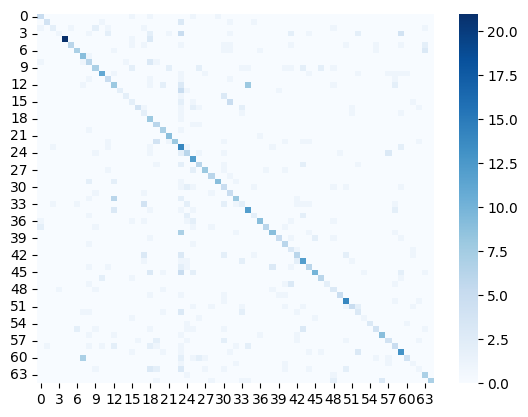

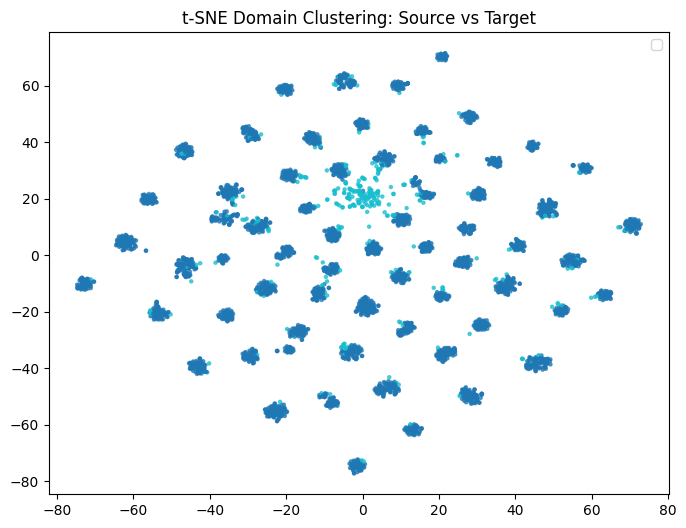

: 

In [ ]:
config = {'epochs':10, 'lr':1e-3, 'batch_size':32, 'weight_decay':1e-3}
model = build_model(truncate_from='layer3')
# model.layer3.grad = False 
analysis(config, cache_store[source], cache_store[target])
analysis(config, source_ds, target_ds)